In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Introduction

In this session, we use Python to visualize and manipulate MRI data. MRI data can be downloaded at [this adress](https://nextcloud.univ-lille.fr/index.php/s/Tsaape5DmBtFaze).

# Exploration of the dataset

We will first explore the file **metadata.csv** in the data directory to compute and display some statistics relative to the dataset. Each line in this file corresponds to a patient with an MR image.

## Data loading

Load the CSV file into a **pandas DataFrame**. Print the number of patients and the column names.

In [2]:
df = pd.read_csv('data/metadata.csv')
print(f"Number of patients : {len(df)}")
print(f"Column names : {df.columns}")

Number of patients : 20
Column names : Index(['sub_id', 'site', 'age', 'sex'], dtype='object')


## Global statistics

Print some statistics:
  - average age
  - standard deviation of age
  - percentage of women

In [3]:
print(f"average age : {df.age.mean():.3f}")
print(f"Standard deviation of age : {df.age.std():.3f}")
print(f"Percentage of women : {sum(df.sex=='F')/len(df)*100:.2f}")

average age : 50.600
Standard deviation of age : 16.955
Percentage of women : 50.00


## Statistics per site

The *site* field in metadata enables to identify the site of MR image acquisition for each patient.

Print the list of site names and the number of patients for each one. The [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [size](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.size.html) functions may be helpful.

In [4]:
df.groupby('site').size()

site
Biograph    5
Guys        5
HH          5
NMorph      5
dtype: int64

Print the following statistics for each site:
  - average age
  - standard deviation of age
  - percentage of women
  
The [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html) functions may be helpful.

In [5]:
df.groupby('site').aggregate({'age':['mean','std'], 'sex':(lambda vals: sum(vals=='F')/len(vals)*100)})

age                 sex
            mean        std <lambda>
site                                
Biograph  68.200  10.425929     60.0
Guys      48.174  17.510589     20.0
HH        49.626  14.577837     80.0
NMorph    36.400   9.476286     40.0

Display boxplots of age distribution for each site. **seaborn.boxplot** may be helpful.

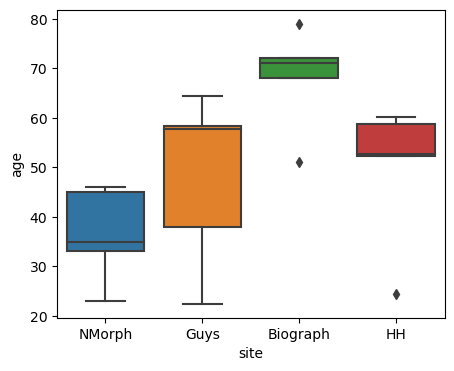

In [6]:
plt.figure(figsize=(5,4))
sns.boxplot(df, x='site', y='age')
plt.show()

# Manipulation/visualization of an MR image and segmentation masks

We will now work on 3 MR images of subject 2:
  1. **2_raw.nii.gz**: MR image of subject 2
  2. **2_brainMask.nii.gz**: corresponding brain mask. $mask[i,j,k] > 0$ means that $brain[i,j,k]$ has been identified as a brain voxel.
  3. **2_seg.nii.gz**: corresponding segmentation mask. Identifies the type of brain tissue in the brain:
      - $mask[i,j,k] = 0 \rightarrow$ non-brain voxel
      - $mask[i,j,k] = 1 \rightarrow$ cerebrospinal fluid (CSF) voxel
      - $mask[i,j,k] = 2 \rightarrow$ gray-matter (GM) voxel
      - $mask[i,j,k] = 3 \rightarrow$ white-matter (WM) voxel

## Data loading

Load the 3 MR images into 3 **numpy.ndarray** with **nibabel.load**.

In [7]:
mri = nib.load('data/2_raw.nii.gz').get_fdata()
brainMask = nib.load('data/2_brainMask.nii.gz').get_fdata()
seg = nib.load('data/2_seg.nii.gz').get_fdata()

## Skullstripping

Use the brain mask to set all non-brain voxels to 0 (skullstripping). Store the result in a new *numpy.ndarray*. **numpy.where** may be helpful.

In [8]:
brain = np.where(brainMask>0, mri, 0)

## Visualization

Use the **imshow** function of *matplotlib* (with `cmap='gray'`) to display a slice (2D image) of the raw image, the skullstripped image and the segmentation. Use the same slice position for the 3 images (e.g. `array[:,:,75]`).

Note: You can use [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) and [Axes.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) to display the three images on one row.

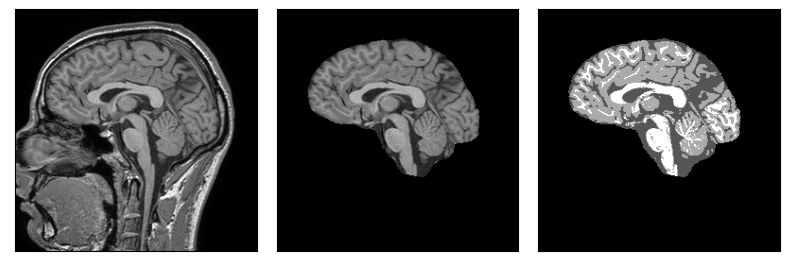

In [9]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,5))
for ax in axs:
    ax.set_xticks(())
    ax.set_yticks(())
axs[0].imshow(np.rot90(mri[:,:,75]), cmap='gray', vmin=0, vmax=2000)
axs[1].imshow(np.rot90(brain[:,:,75]), cmap='gray', vmin=0, vmax=2000)
axs[2].imshow(np.rot90(seg[:,:,75]), cmap='gray')
plt.tight_layout()
plt.show()

#  Histogram of intensities

Create a function `compute_histogram` for computing histograms of intensities (voxel values). This function takes 3 arguments:
  - `mri`: *numpy.ndarray* corresponding to the MRI
  - `mask`: *numpy.ndarray* of booleans corresponding to voxels of interest
  - `bins`: array of bin edges of the resulting histogram
  
The function returns the values of the histogram of intensities inside the region defined by `mask`. Call **numpy.histogram** inside this function.

In [10]:
def compute_histogram(mri,mask,bins):
    return np.histogram(mri[mask], bins=bins)[0]

The following function will be used to plot histograms (you can adapt it if you want):

In [11]:
def plot_histogram(hist, bins, label=None):
    hist = np.insert(hist, 0, hist[0])
    plt.plot(bins, hist, drawstyle='steps', label=label)

## Single subject

Use these two functions to plot the histogram of **brain** intensities of the subject 2. We will use the following histogram bin edges `np.arange(start=0, stop=1600, step=30)`.

In [12]:
bins = np.arange(start=0, stop=1600, step=30)

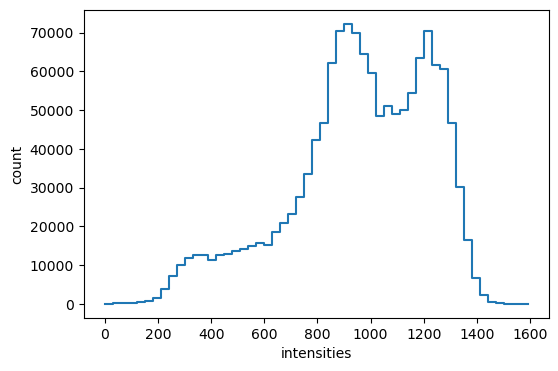

In [13]:
hist = compute_histogram(mri, brainMask>0, bins)

plt.figure(figsize=(6,4))
plt.xlabel('intensities')
plt.ylabel('count')
plot_histogram(hist, bins)
plt.show()

Now use these two functions and the segmentation matrix you previously loaded (*2_seg.nii.gz*) to plot 3 histograms for subject 2 in one figure:
  - CSF intensities
  - GM intensities
  - WM intensities
  
Note: You can use the `label` parameter of `compute_histogram` and the *matplotlib.pyplot.legend* function.

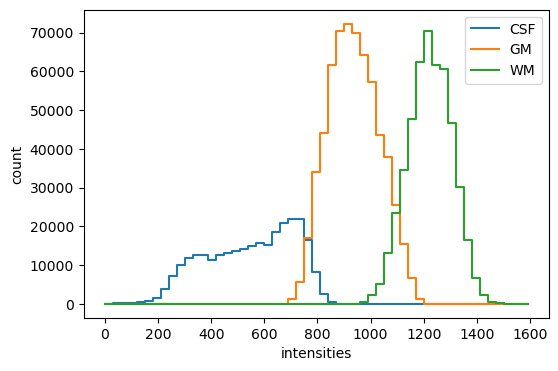

In [14]:
plt.figure(figsize=(6,4))
plt.xlabel('intensities')
plt.ylabel('count')
for v,name in zip((1,2,3),('CSF','GM','WM')):
    hist = compute_histogram(mri, seg==v, bins)
    plot_histogram(hist,bins,label=name)
plt.legend()
plt.show()

## Average per site

In the data directory, you can find for each subject the MR image (*\<sub_id\>_raw.nii.gz*) and the corresponding brain mask (*\<sub_id\>_brainMask.nii.gz*).

For each site, compute the average histogram of **brain** intensities with `compute_histogram` (sum of the individual histograms divided by the number of subject within the site).

In [15]:
sites = df.site.unique()
mean_histograms = np.zeros((len(sites),len(bins)-1))
for i,site in enumerate(sites):
    df_tmp = df[df.site==site]
    for id_ in df_tmp.sub_id:
        mri = nib.load(f"data/{id_}_raw.nii.gz").get_fdata()
        mask = nib.load(f"data/{id_}_brainMask.nii.gz").get_fdata()
        hist = compute_histogram(mri, mask>0, bins)
        mean_histograms[i] += hist
    mean_histograms[i] /= len(df_tmp)

Plot these histograms with `plot_histogram`.

Note: You can use *matplotlib.pyplot.xlim* to change the limit of the x axis.

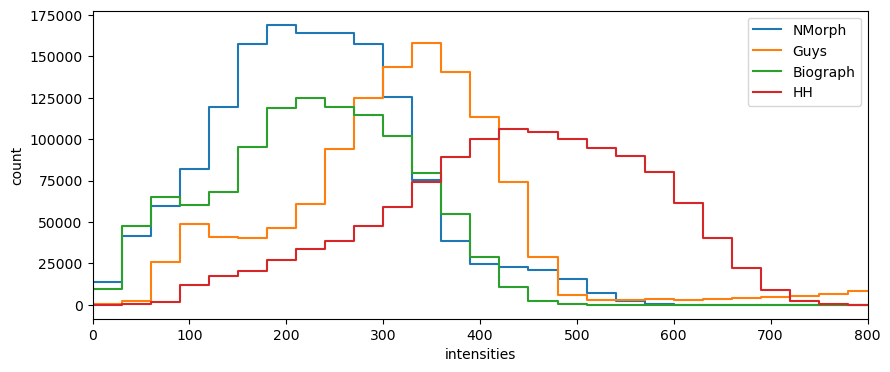

In [16]:
plt.figure(figsize=(10,4))
plt.xlabel('intensities')
plt.ylabel('count')
plt.xlim((0,800))
for i in range(len(sites)):
    plot_histogram(mean_histograms[i], bins, label=sites[i])
plt.legend()
plt.show()

# Intensity normalization

## Z-score normalization

Z-score normalization standardizes the mean and the standard deviation of brain intensities within each MRI with the following formula:

$x_{zscore} = \frac{x_{base}-\mu_b}{\sigma_b}$
$\mu_b$ and $\sigma_b$ correspond respectively to mean and standard deviation of brain intensities within the original MRI $x_{base}$.

Create the function `zscore` that takes an MRI and the corresponding brain mask as arguments and returns the z-zcore normalized MRI.

In [17]:
def zscore(mri,mask):
    vals = mri[mask]
    return (mri-vals.mean())/vals.std()

## Application to a single subject

Apply this function to subject 2 and print the mean and standard deviation of the brain intensities of the normalized image to verify that you find the correct values (0 and 1).

In [18]:
mri = nib.load('data/2_raw.nii.gz').get_fdata()
brainMask = nib.load('data/2_brainMask.nii.gz').get_fdata()

normalized = zscore(mri,brainMask>0)
vals = normalized[brainMask>0]
print(f"mean = {vals.mean():.3f}")
print(f"std = {vals.std():.3f}")

mean = -0.000
std = 1.000


## Application to all subjects and histograms

Compute the average histogram of brain intensities for each site as you did previously but with z-score normalized images. This time we will use the following histogram bin edges: `np.arange(start=-4,stop=4,step=0.15)`.

In [19]:
bins = np.arange(start=-4, stop=4, step=0.15)

In [20]:
mean_histograms_norm = np.zeros((len(sites),len(bins)-1))
for i,site in enumerate(sites):
    df_tmp = df[df.site==site]
    for id_ in df_tmp.sub_id:
        mri = nib.load(f"data/{id_}_raw.nii.gz").get_fdata()
        mask = nib.load(f"data/{id_}_brainMask.nii.gz").get_fdata()
        norm = zscore(mri, mask>0)
        hist = compute_histogram(norm, mask>0, bins)
        mean_histograms_norm[i] += hist
    mean_histograms_norm[i] /= len(df_tmp)

Now, plot the average histograms with `plot_histogram` as you did previously.

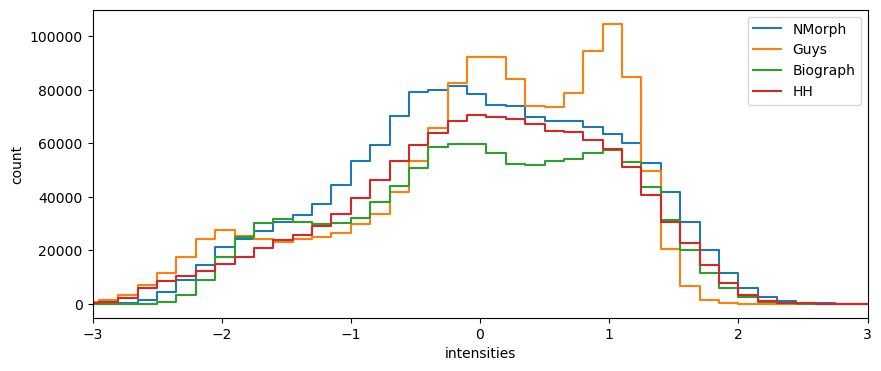

In [21]:
plt.figure(figsize=(10,4))
plt.xlabel('intensities')
plt.ylabel('count')
plt.xlim((-3,3))
for i in range(len(sites)):
    plot_histogram(mean_histograms_norm[i], bins, label=sites[i])
plt.legend()
plt.show()

Comment the histograms in comparison with those you obtained previously without z-score normalization.

The average histograms of brain intensities are more similar between sites after z-score normalization.